In [47]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA 
import random
from collections import defaultdict

In [96]:
# Create a simple graph to work with


def create_simple_graph():
    """Create a simple graph that's easy to understand."""
    G = nx.Graph()
    
    # Add edges to create a small network
    edges = [
        ("A", "B"), ("A", "C"), ("A", "D"), ("A", "E"),
        ("B", "C"), ("B", "E"),
        ("C", "D"), ("C", "F"),
        ("D", "F"), ("D", "G"),
        ("E", "F"), ("E", "H"),
        ("F", "G"), ("F", "H"),
        ("G", "H"), ("G", "A"),
        ("H", "C"), ("H", "D"), ("H", "B"),
        ("I", "A"), ("I", "F"), ("I", "D"),
        ("J", "E"), ("J", "G"),
        ("K", "B"), ("K", "C"), ("K", "H")
    ]
    
    G.add_edges_from(edges)
    return G

In [97]:
def visualize_graph(G, title = "Graph Structure"):
    """Visualize the graph"""
    plt.figure(figsize = (8, 6))
    pos = nx.spring_layout(G, seed = 42)
    nx.draw(G, pos, with_labels = True, node_color = "lightblue", node_size = 1000, font_size = 16, font_weight = "bold")
    plt.title(title)
    plt.show()

In [98]:
# Generate Random Walks

def do_random_walk(graph, start_node, walk_length):
    """
    Do a single random walk starting from start_node.
    This is like taking a random path through the graph.
    """
    
    walk = [start_node]  # Start with the starting node
    current_node = start_node
    
    
    for step in range(walk_length - 1):
        # Get all the neighbors of current node
        neighbors = list(graph.neighbors(current_node))
        
        if not neighbors:  # No neighbors, stop walking
            break
        
        # Pick a random neighbor
        walk_node = random.choice(neighbors)
        walk.append(walk_node)
        current_node = walk_node
        
    return walk

In [99]:
def generate_all_walks(graph, num_walks_per_node, walk_length):
    """
    Generate many random walks from each node.
    Think of this as exploring the graph from evert possible starting point.
    """
    all_walks = []
    nodes = list(graph.nodes())
    
    print(f"Generating {num_walks_per_node} walks of length {walk_length} from each node ...")
    
    for node in nodes:
        for walk_num in range(num_walks_per_node):
            walk = do_random_walk(graph, node, walk_length)
            all_walks.append(walk)
            
    print(f"Total Walks Generated: {len(all_walks)}")
    return all_walks

In [100]:
def show_sample_walks(walks, num_samples = 5):
    """Show some example walks"""
    print("\nSample Random Walks:")
    for i in range(min(num_samples, len(walks))):
        walk_str = "->".join(walks[i])
        print(f"Walk {i + 1}: {walk_str}")

In [101]:
# Create Training Data (Context Pairs)

def create_training_pairs(walks, window_size):
    """
    Create training pairs from walks.
    For each node in a walk, its "context" is the nearby nodes in the same walk
    """
    
    pairs = []
    
    print(f"\nCreating training pairs with window size {window_size}...")
    
    for walk in walks:
        for i, center_node in enumerate(walk):
            # Look at nodes within window_size steps
            start_idx = max(0, i - window_size)
            end_idx = min(len(walk), i + window_size + 1)
            
            for j in range(start_idx, end_idx):
                if i != j:  # Don't pair the node with itself
                    context_node = walk[j]
                    pairs.append((center_node, context_node))
                    
    print(f"Created {len(pairs)} training pairs")
    return pairs

In [102]:
def show_simple_pairs(pairs, num_samples = 10):
    """Show some sample training pairs"""
    print("\nSample training pairs (center_node, context_node):")
    for i in range(min(num_samples, len(pairs))):
        center, context = pairs[i]
        print(f"({center}, {context})")

In [103]:
# Simple Word2Vec-like Model

def initialize_embeddings(nodes, embedding_dim):
    """
    Create random initial embeddings for each node.
    Each node gets a vector of random numbers.
    """
    embeddings = {}
    
    print(f"\nInitializing {embedding_dim}-dimensional embeddings for {len(nodes)} nodes...")
    
    for node in nodes:
        # Random vector between -0.5 and 0.5
        embeddings[node] = np.random.uniform(-0.5, 0.5, embedding_dim)
        
    return embeddings

In [104]:
def sigmoid(x):
    """Sigmoid function: converts any number to a probability between 0 and 1"""
    # Clip to prevent overflow
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

In [105]:
def train_simple_skipgram(pairs, embeddings, learning_rate, epochs):
    """
    Simple training loop - this is where the magic happens!
    We want nodes that appear together in walks to have similar embeddings.
    """
    
    nodes = list(embeddings.keys())
    
    print(f"\nTraining for {epochs} epochs with learning rate {learning_rate}...")
    
    for epoch in range(epochs):
        total_loss = 0
        random.shuffle(pairs)  # Shuffle for better training
        
        
        for center_node, context_node in pairs:
            # Get embeddings for both nodes
            center_emb = np.array(embeddings[center_node])
            context_emb = np.array(embeddings[context_node])
            
            # Calculate how similar they are (dot_product)
            similarity = np.dot(center_emb, context_emb)
            
            # Convert to probability using sigmoid
            prob = sigmoid(similarity)
            
            # We want this probability to be high (close to 1)
            # So we calculate the error
            error = 1 - prob
            
            # Update embeddings to make them more similar
            # This is gradient descent
            gradient = error * learning_rate
            
            # Create new updated embeddings
            new_center_emb = center_emb + gradient * context_emb
            new_context_emb = context_emb + gradient * center_emb
            
            # Store back in dictionary
            embeddings[center_node] = new_center_emb.tolist()
            embeddings[context_node] = new_context_emb.tolist()
            
            total_loss += -np.log(prob + 1e-10)  # Add small value to prevent log(0)
            
        avg_loss = total_loss / len(pairs)
        print(f"Epoch {epoch + 1} / {epochs}, Average Loss: {avg_loss:.4f}")
        
    print("Training Completed!")
    return embeddings

In [106]:
# Visualize and Analyze Results

def visualize_embeddings(embeddings, title = "Node Embeddings"):
    """
    Visualize the learned embeddings
    Since embeddings might be high-dimensional, we use PCA to reduce to 2D.
    """
    nodes = list(embeddings.keys())
    embedding_matrix = np.array([embeddings[node] for node in nodes])
    
    # Reduce to 2D using PCA
    if embedding_matrix.shape[1] > 2:
        pca = PCA(n_components = 2)
        embedding_2d = pca.fit_transform(embedding_matrix)
    else:
        embedding_2d = embedding_matrix
        
    plt.figure(figsize = (10, 8))
    
    # Plot each node
    for i, node in enumerate(nodes):
        x, y = embedding_2d[i]
        plt.scatter(x, y, s = 300, alpha = 0.7)
        plt.annotate(str(node), (x, y), ha = "center", va = "center", fontsize = 12, fontweight = "bold")
        
    plt.title(title)
    plt.xlabel("First Principal Component")
    plt.ylabel("Second Principal Component")
    plt.grid(True, alpha = 0.3)
    plt.show()
        
    

In [107]:
def find_similar_nodes(target_node, embeddings, top_k = 3):
    """
    Find nodes with similar embeddings to the target node.
    """
    target_embedding = embeddings[target_node]
    similarities = {}
    
    for node, embedding in embeddings.items():
        if node != target_node:
            # Calculate cosine similarity
            dot_product = np.dot(target_embedding, embedding)
            norm_target = np.linalg.norm(target_embedding)
            norm_node = np.linalg.norm(embedding)
            similarity = dot_product / (norm_target * norm_node)
            similarities[node] = similarity
            
    # Sort by similarity (highest first)
    sorted_nodes = sorted(similarities.items(), key = lambda x: x[1], reverse = True)
    return sorted_nodes[:top_k]

In [108]:
def compare_embeddings_before_after(nodes, embedding_dim):
    """Compare random embeddings vs trained embeddings"""
    # Random Embeddings
    random_emb = initialize_embeddings(nodes, embedding_dim)
    
    plt.figure(figsize = (15, 5))
    
    
    # Plot random embeddings
    plt.subplot(1, 3, 1)
    visualize_embeddings_subplot(random_emb, "Random Embeddings")
    
    return random_emb

In [109]:
def visualize_embeddings_subplot(embeddings, title):
    """Helper function for subplot visualization"""
    nodes = list(embeddings.keys())
    embedding_matrix = np.array([embeddings[node] for node in nodes])
    
    if embedding_matrix.shape[1] > 2:
        pca = PCA(n_components = 2)
        embedding_2d = pca.fit_transform(embedding_matrix)
    else:
        embedding_2d = embedding_matrix
        
    for i, node in enumerate(nodes):
        x, y = embedding_2d[i]
        plt.scatter(x, y, s = 200, alpha = 0.7)
        plt.annotate(str(node), (x, y), ha = "center", va = "center", fontsize = 10)
    
    plt.title(title)
    plt.grid(True, alpha = 0.3)

In [115]:
def run_deepwalk_step_by_step():
    """Run the complete DeepWalk algorithm with visualizations"""
    
    print("="*60)
    print("DEEPWALK ALGORITHM - STEP BY STEP")
    print("="*60)
    
    # Create and Visualize the Graph
    print("\nCreating a simple graph...")
    G = create_simple_graph()
    print(f"Graph has {G.number_of_nodes()} nodes: {list(G.nodes())}")
    print(f"Graph has {G.number_of_edges()} edges")
    visualize_graph(G)
    
    # Generate Random Walks
    print(f"\nGenerating Random Walks...")
    walks = generate_all_walks(G, num_walks_per_node = 15, walk_length = 8)
    show_sample_walks(walks)
    
    # Create Training Pairs
    print(f"\nCreating Training Data...")
    pairs = create_training_pairs(walks, window_size = 2)
    show_simple_pairs(pairs)
    
    # Initialize and train embeddings
    print(f"\nTraining node embeddings...")
    nodes = list(G.nodes())
    embeddings = initialize_embeddings(nodes, embedding_dim = 10)
    
    # Show intial random embeddings
    print("\nBefore training:")
    visualize_embeddings(embeddings, "Initial Random Embeddings")
    
    # Train the embeddings
    trained_embeddings = train_simple_skipgram(
        pairs, embeddings, learning_rate = 0.1, epochs = 50
    )
    
    # Visualize Results
    print(f"\nAnalyzing Results...")
    print(f"\nAfter Training:")
    visualize_embeddings(trained_embeddings, "Trained DeepWalk Embeddings")
    
    # Test Similarity
    test_node = nodes[0]
    similar_nodes = find_similar_nodes(test_node, trained_embeddings)
    
    print(f"\nNodes most similar to '{test_node}':")
    for node, similarity in similar_nodes:
        print(f"  {node}: {similarity:.3f}")
    
    print("\n" + "="*60)
    print("DEEPWALK COMPLETED!")
    print("="*60)
    
    return G, trained_embeddings
    

DEEPWALK ALGORITHM - STEP BY STEP

Creating a simple graph...
Graph has 11 nodes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']
Graph has 27 edges


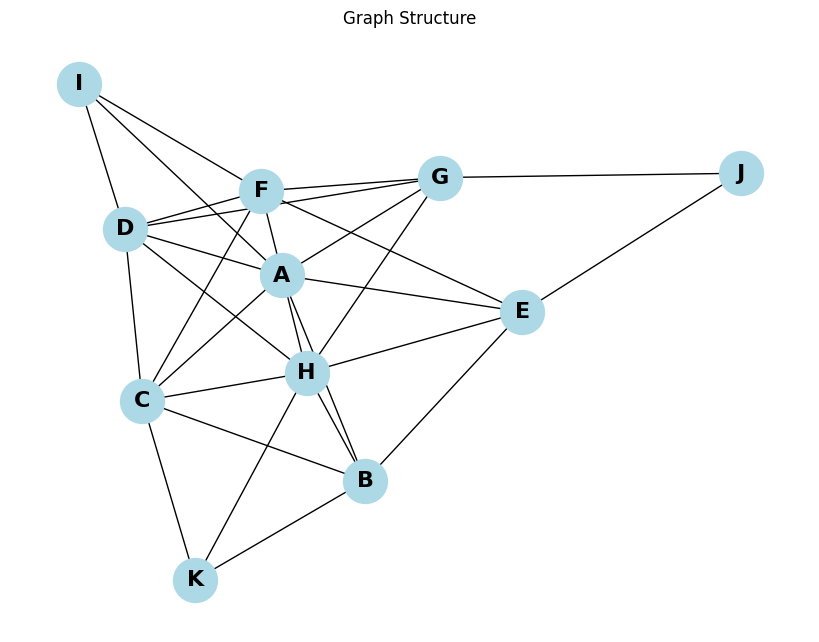


Generating Random Walks...
Generating 15 walks of length 8 from each node ...
Total Walks Generated: 165

Sample Random Walks:
Walk 1: A->B->H->C->H->G->D->C
Walk 2: A->B->A->I->A->E->F->C
Walk 3: A->C->A->C->H->K->B->C
Walk 4: A->D->F->D->C->H->F->H
Walk 5: A->C->B->C->A->G->F->H

Creating Training Data...

Creating training pairs with window size 2...
Created 4290 training pairs

Sample training pairs (center_node, context_node):
(A, B)
(A, H)
(B, A)
(B, H)
(B, C)
(H, A)
(H, B)
(H, C)
(H, H)
(C, B)

Training node embeddings...

Initializing 10-dimensional embeddings for 11 nodes...

Before training:


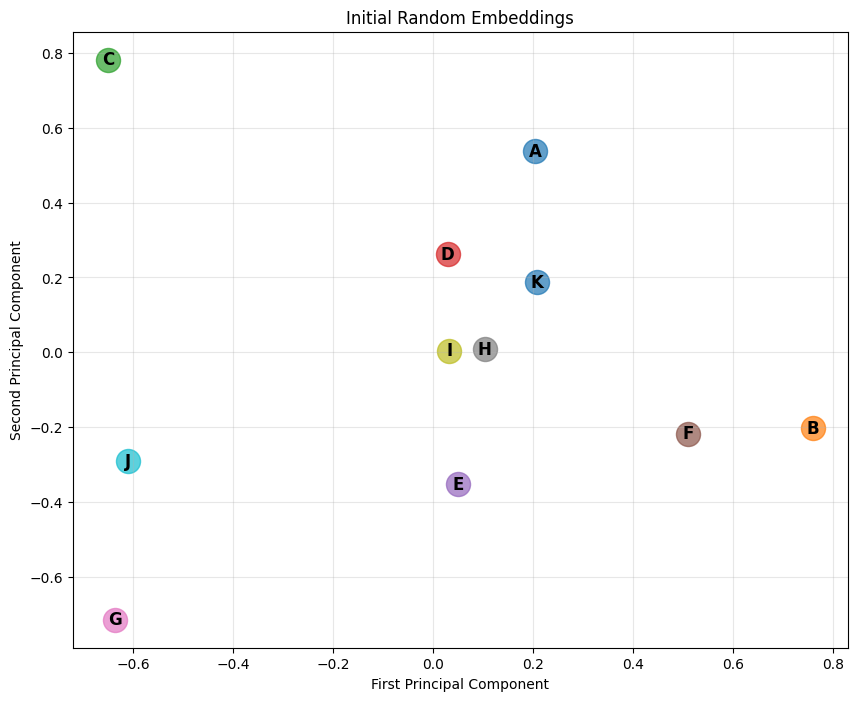


Training for 50 epochs with learning rate 0.1...
Epoch 1 / 50, Average Loss: 0.0371
Epoch 2 / 50, Average Loss: 0.0008
Epoch 3 / 50, Average Loss: 0.0004
Epoch 4 / 50, Average Loss: 0.0003
Epoch 5 / 50, Average Loss: 0.0002
Epoch 6 / 50, Average Loss: 0.0002
Epoch 7 / 50, Average Loss: 0.0001
Epoch 8 / 50, Average Loss: 0.0001
Epoch 9 / 50, Average Loss: 0.0001
Epoch 10 / 50, Average Loss: 0.0001
Epoch 11 / 50, Average Loss: 0.0001
Epoch 12 / 50, Average Loss: 0.0001
Epoch 13 / 50, Average Loss: 0.0001
Epoch 14 / 50, Average Loss: 0.0001
Epoch 15 / 50, Average Loss: 0.0001
Epoch 16 / 50, Average Loss: 0.0001
Epoch 17 / 50, Average Loss: 0.0000
Epoch 18 / 50, Average Loss: 0.0000
Epoch 19 / 50, Average Loss: 0.0000
Epoch 20 / 50, Average Loss: 0.0000
Epoch 21 / 50, Average Loss: 0.0000
Epoch 22 / 50, Average Loss: 0.0000
Epoch 23 / 50, Average Loss: 0.0000
Epoch 24 / 50, Average Loss: 0.0000
Epoch 25 / 50, Average Loss: 0.0000
Epoch 26 / 50, Average Loss: 0.0000
Epoch 27 / 50, Average 

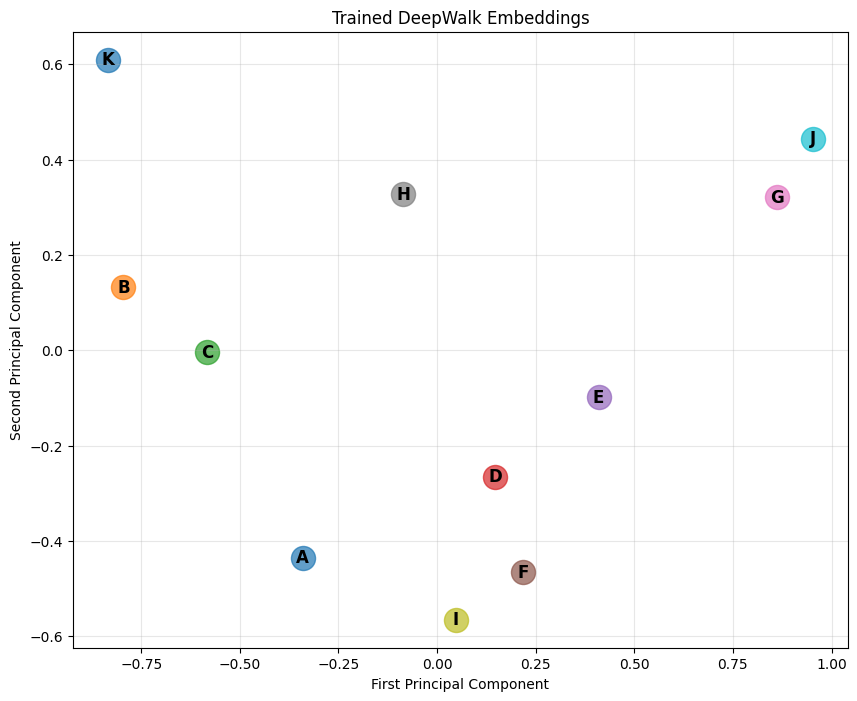


Nodes most similar to 'A':
  C: 0.977
  I: 0.976
  D: 0.965

DEEPWALK COMPLETED!


In [116]:
graph, final_embeddings = run_deepwalk_step_by_step()

In [117]:
nodes = list(graph.nodes())
trained_embeddings = final_embeddings

test_node = nodes[3]
similar_nodes = find_similar_nodes(test_node, trained_embeddings)

print(f"\nNodes most similar to '{test_node}':")
for node, similarity in similar_nodes:
    print(f"  {node}: {similarity:.3f}")


Nodes most similar to 'D':
  F: 0.981
  E: 0.971
  A: 0.965
